# Big Mart Sales Prediction

The data scientists at Big Mart have collected 2013 sales data for 1559 products across 10 stores in different cities. Certain attributes of each product and store have been defined. The aim is to build a predictive model to predict the sales of each product at a particular outlet.

Using this model, Big Mart will try to understand the properties of products and outlets which play a key role in increasing sales.

## Library Imports

In [123]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

In [124]:
# seed for random number generator
SEED = 1729

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


## Exploratory Data Analysis

### Basic Information

In [126]:
# load training and test data sets

sales_train = pd.read_csv('train_bmsales.csv')
sales_test = pd.read_csv('test_bmsales.csv')

In [127]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [128]:
sales_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [129]:
sales_train.drop_duplicates(inplace=True)
sales_train.shape

(8523, 12)

In the training data set, Item_Weight and Outlet_Size columns have some null values. Item_Outlet_Sales is the target variable to be predicted. There are no duplicate rows in the training data set.

In [130]:
sales_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In the test data set, Item_Weight and Outlet_Size columns have some null values, same as those in the training data set.

In [131]:
sales_test.drop_duplicates(inplace=True)
sales_test.shape

(5681, 11)

In [132]:
sales_train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [133]:
sales_test.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4705.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,1997.828903
std,4.664849,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1985.000000
25%,8.645000,0.027047,94.412000,1987.000000
50%,12.500000,0.054154,141.415400,1999.000000
75%,16.700000,0.093463,186.026600,2004.000000
max,21.350000,0.323637,266.588400,2009.000000


Variances and means of the (numeric) features differ from each other by orders of magnitude in both the training and test data sets.

In [134]:
for col in sales_train.select_dtypes(include='object').columns:
    print(sales_train[col].value_counts())

FDW13    10
FDG33    10
NCQ06     9
FDW26     9
FDQ40     9
         ..
FDK57     1
FDO33     1
FDQ60     1
FDN52     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
OUT027    935
OUT013    932
OUT035    930
OUT046    930
OUT049    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64
Medium    279

Item_Fat_Content has inconsistently named categories. e.g. Low Fat, LF, and low fat.

In [135]:
# all categorical columns list
cat_cols = [col for col in sales_train.columns if sales_train[col].dtype == 'object']

# columns that have different categories in training and test data sets

bad_cols = [col for col in cat_cols if
            set(sales_train[col]) != set(sales_test[col])]

In [136]:
bad_cols

['Item_Identifier']

In [137]:
len(set(sales_test['Item_Identifier']).difference(set(sales_train['Item_Identifier'])))

0

No discrepencies with the number of categories or their names between the training and test data sets except Item_Identifier. Some item records exists only in the training set. This will not pose any problem.

### Distributions

#### Distribution of Numeric Features

In [138]:
# calculate pair-wise linear correlation between numeric features

sales_train.loc[:, ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']].corr().round(3)

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
Item_Weight,1.000,-0.014,0.027,0.014
Item_Visibility,-0.014,1.000,-0.001,-0.129
Item_MRP,0.027,-0.001,1.000,0.568
Item_Outlet_Sales,0.014,-0.129,0.568,1.000


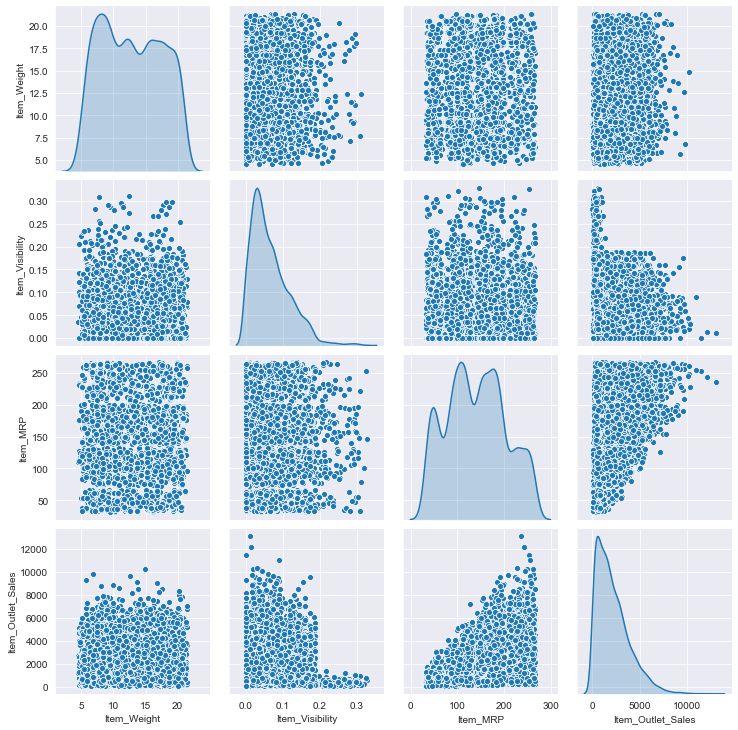

In [139]:
sns.pairplot(sales_train.loc[:, ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']], 
             diag_kind='kde')
plt.show()

We can make the following observations from these graphs:

1. Sales distribution is highly right-skewed indicating there are a few items with very high sales.
2. Item visibility distribution is also highly righ-skewed with a few very highly visible items.
3. MRP and weight distributions are multi-modal.
4. The numeric predictor features do not show any notable correlation with each other. Sales has moderate positive correlation (correlation coeff = 0.568) with MRP. MRP could be a good predictor of sales.

Numerical predictors need to standardized. Tranforming them to be closer to Gaussian distribution may also help.

#### Distribution of Categorical Features

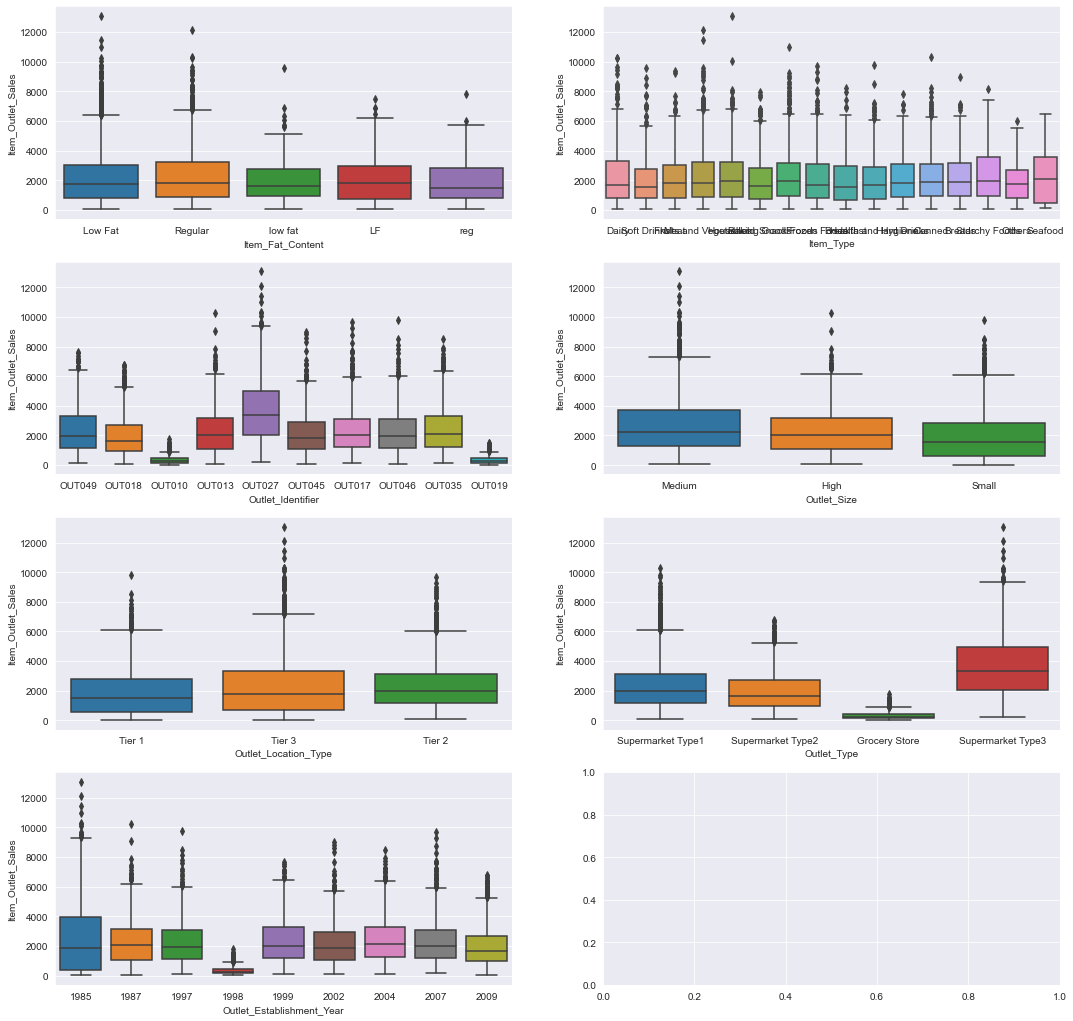

In [140]:
# distribution of item sales by categorical features

feature_names = ['Item_Fat_Content',
                 'Item_Type',
                 'Outlet_Identifier',
                 'Outlet_Size',
                 'Outlet_Location_Type',
                 'Outlet_Type', 
                 'Outlet_Establishment_Year']

fig, ax1 = plt.subplots(4,2,figsize=(18, 18))

k = 0
for i in range(4):
    for j in range(2):
        if k <= (len(feature_names) - 1):
            g = sns.boxplot(x=feature_names[k], y=sales_train['Item_Outlet_Sales'], 
                        data=sales_train[feature_names], ax=ax1[i][j])
            k = k + 1    
plt.show()



Item sales show notable variability by outlet type and outlet identifier. These two features might be important for predicting the sales. Outlet establishment year 1998 shows significantly low sales compared to all other years. (Note: We regard the establishment year as categorical variable although it is defined as numeric in the data set. Year as an identifier and not its specific numeric value is useful for the analysis.)

## Data Preprocessing

In [141]:
# remove features not useful for prediction
clean_train = sales_train.drop(['Item_Identifier'], axis=1)
clean_train.shape

(8523, 11)

In [142]:
clean_test = sales_test.drop(['Item_Identifier'], axis=1)
clean_test.shape

(5681, 10)

In [143]:
# convert the year column to categorical data type

clean_train['Outlet_Establishment_Year'] = clean_train['Outlet_Establishment_Year'].astype('object')
clean_test['Outlet_Establishment_Year'] = clean_test['Outlet_Establishment_Year'].astype('object')

In [170]:
# correct the misspelt categories

sales_train['Item_Fat_Content'] = sales_train.Item_Fat_Content.replace({'low fat':'Low Fat',
                                                                        'LF':'Low Fat',
                                                                        'reg':'Regular'})

sales_test['Item_Fat_Content'] = sales_test.Item_Fat_Content.replace({'low fat':'Low Fat',
                                                                        'LF':'Low Fat',
                                                                        'reg':'Regular'})

print(sales_train.Item_Fat_Content.value_counts())
print(sales_test.Item_Fat_Content.value_counts())


Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64
Low Fat    3668
Regular    2013
Name: Item_Fat_Content, dtype: int64


In [145]:
X = clean_train.drop(['Item_Outlet_Sales'], axis=1)
y = clean_train['Item_Outlet_Sales']

In [146]:
# list for numerical and categorical feature (column) names

numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']

In [147]:
numerical_cols

['Item_Weight', 'Item_Visibility', 'Item_MRP']

In [148]:
categorical_cols

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [149]:
# create training and validation data sets

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [150]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(6392, 10) (6392,)
(2131, 10) (2131,)


In [151]:
# preprocessing for numerical features: 

# fill null values with mean value of the feature column and
# power transform them in order to make their distribution close to Gaussian distribution and 
# standardize the scale with mean=0 and stddev=1.

# This is required because: 1. linear models assume Gaussian distribution of predictor variables and 
# 2. to ensure that the results of linear models and 
# those that use linear distance measure (like Euclidean distance) are not unduely distorted because of 
# some features with very high variance or those with very high range of values.

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), 
                                  ('scaler', PowerTransformer(method='yeo-johnson', standardize=True))])

# preprocessing for categorical features: fill null values with the most commonly occurring value and
# apply one-hot encoding

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, numerical_cols), 
                                               ('cat', cat_transformer, categorical_cols)])

## Model Training and Evaluation

In [152]:
# create pipeline consisting of preprocessing and the model
# pipeline dictionary consists of one pipeline for each model to be evaluated

pipelines = {'ridge': Pipeline(steps=[('preprocessor', preprocessor), 
                                      ('ridge', Ridge(random_state=SEED))]),
             
            'rf': Pipeline(steps=[('preprocessor', preprocessor), 
                                  ('rf', RandomForestRegressor(random_state=SEED))]),
            
             'gb': Pipeline(steps=[('preprocessor', preprocessor), 
                                   ('gb', GradientBoostingRegressor(n_iter_no_change=10, tol=0.001, random_state=SEED))]),
            
             'svr_linear': Pipeline(steps=[('preprocessor', preprocessor), 
                                           ('svr_linear', SVR(kernel='linear', tol=0.001))]),
            
             'svr_rbf': Pipeline(steps=[('preprocessor', preprocessor), ('svr_rbf', SVR(kernel='rbf', tol=0.001))])}


In [153]:
# define hyperparameter distributions

ridge_params = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

rf_params = {'rf__n_estimators': [100, 300, 500],
            'rf__min_samples_split': [2, 4, 6]}

gb_params = {'gb__n_estimators': [100, 300, 500],
            'gb__learning_rate': [0.0001, 0.001, 0.01, 0.1] }

svr_linear_params = {'svr_linear__C': np.logspace(-3, 3, 7)}

svr_rbf_params = {'svr_rbf__C': np.logspace(-3, 3, 7),
                 'svr_rbf__gamma': np.logspace(-3, 3, 7)}

param_dist = {'ridge': ridge_params,
             'rf': rf_params,
             'gb': gb_params,
             'svr_linear': svr_linear_params,
             'svr_rbf': svr_rbf_params}

In [156]:
# train each model, tune its hyperparameters and evaluate its performance using k-fold cross-validation

fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, param_grid[name], refit=True, cv=5, scoring='neg_root_mean_squared_error')
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print('{} CV on training data set complete.'.format(name))

ridge CV on training data set complete.
rf CV on training data set complete.
gb CV on training data set complete.
svr_linear CV on training data set complete.
svr_rbf CV on training data set complete.


In [162]:
# print the best CV RMSE on validation data set

for name, model in fitted_models.items():
    rmse = -1*(model.best_score_)
    print(name, 'Best CV Training RMSE:', rmse.round(4))

ridge Best CV Training RMSE: 1134.2633
rf Best CV Training RMSE: 1136.907
gb Best CV Training RMSE: 1082.3495
svr_linear Best CV Training RMSE: 1149.4461
svr_rbf Best CV Training RMSE: 1119.0044


In [161]:
# calculate RMSE of fitted models on the validation data set

for name, model in fitted_models.items():
    rmse = mean_squared_error(y_valid, model.predict(X_valid), squared=False)
    print(name, 'Validation RMSE:', rmse.round(4))

ridge Validation RMSE: 1135.2126
rf Validation RMSE: 1116.343
gb Validation RMSE: 1084.2606
svr_linear Validation RMSE: 1156.6085
svr_rbf Validation RMSE: 1117.1998


GradientBoostingRegressor has the lowest RMSE on both training and validation data sets. This model is expected to perform very well on unseen data as the training and validation errors are very close.

Item sales in the training data has mean=2181 and stdev=1706. This model predicts the sales which are off by 1084 on average. The error is close to the standard deviation of the data and hence, considered resonably good.

In [163]:
# hyperparameters of the best model

print(best_model.best_params_)

{'gb__learning_rate': 0.01, 'gb__n_estimators': 500}


In [159]:
# save the best model

best_model = fitted_models['gb']

from joblib import dump, load
dump(best_model, 'bigmart.joblib')


['bigmart.joblib']

## Predictions on Test Data

In [178]:
y_pred = best_model.predict(clean_test)

In [185]:
output = pd.DataFrame({'Item_Identifier': sales_test['Item_Identifier'],
                      'Outlet_Identifier': sales_test['Outlet_Identifier'],
                      'Item_Outlet_Sales': y_pred})

In [186]:
output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5681 entries, 0 to 5680
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item_Identifier    5681 non-null   object 
 1   Outlet_Identifier  5681 non-null   object 
 2   Item_Outlet_Sales  5681 non-null   float64
dtypes: float64(1), object(2)
memory usage: 177.5+ KB


In [187]:
output.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1650.146217
1,FDW14,OUT017,1423.074891
2,NCN55,OUT010,706.212734
3,FDQ58,OUT017,2522.334766
4,FDY38,OUT027,5826.812330


In [188]:
# create comma-seperated file for submission to online competition

output.to_csv('my_submission.csv', index=False, header=True)
